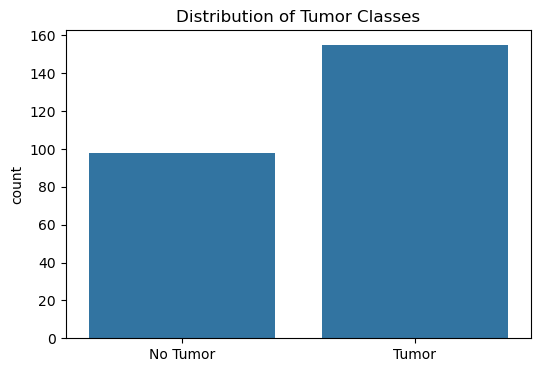

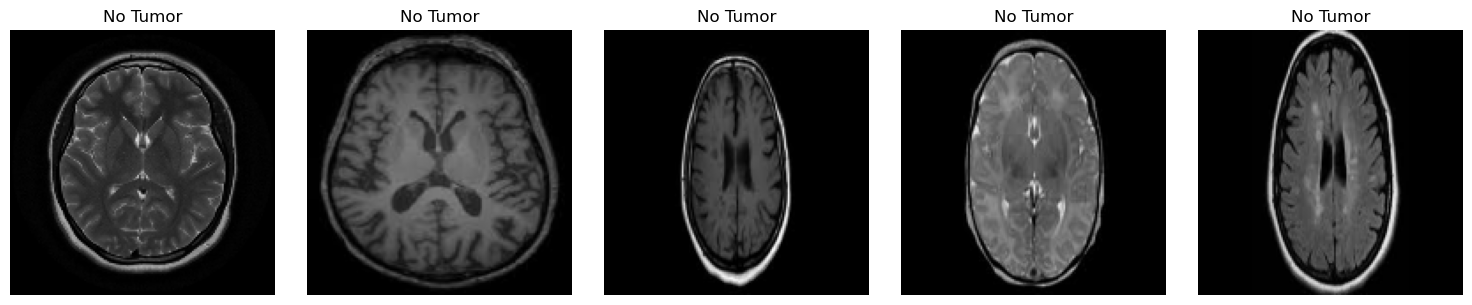

Epoch 1/10
7/7 [==============================] - 1s 135ms/step - loss: 1.4149 - accuracy: 0.5297 - val_loss: 0.4884 - val_accuracy: 0.7647
Epoch 2/10
7/7 [==============================] - 1s 100ms/step - loss: 0.5911 - accuracy: 0.7574 - val_loss: 0.4379 - val_accuracy: 0.8235
Epoch 3/10
7/7 [==============================] - 1s 98ms/step - loss: 0.4829 - accuracy: 0.8020 - val_loss: 0.3761 - val_accuracy: 0.8039
Epoch 4/10
7/7 [==============================] - 1s 97ms/step - loss: 0.4845 - accuracy: 0.7673 - val_loss: 0.4496 - val_accuracy: 0.8235
Epoch 5/10
7/7 [==============================] - 1s 104ms/step - loss: 0.4497 - accuracy: 0.8465 - val_loss: 0.3607 - val_accuracy: 0.8824
Epoch 6/10
7/7 [==============================] - 1s 100ms/step - loss: 0.3485 - accuracy: 0.8663 - val_loss: 0.3123 - val_accuracy: 0.9020
Epoch 7/10
7/7 [==============================] - 1s 98ms/step - loss: 0.3055 - accuracy: 0.8663 - val_loss: 0.2736 - val_accuracy: 0.9412
Epoch 8/10
7/7 [=======

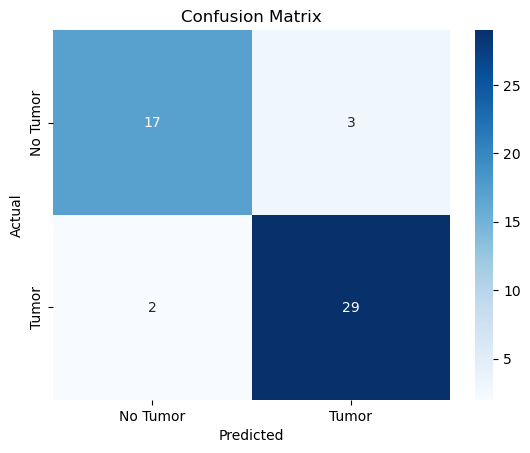

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 15ms/step


In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import gradio as gr

# ---------- Load Dataset ----------
def load_data(data_dir, img_size=(150, 150)):
    X, y = [], []
    for label, folder in enumerate(["no", "yes"]):
        path = os.path.join(data_dir, folder)
        for file in os.listdir(path):
            img_path = os.path.join(path, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(label)
    return np.array(X), np.array(y)

data_dir = r"C:\Users\haste\Downloads\archive\brain_tumor_dataset"
X, y = load_data(data_dir)

# ---------- EDA ----------
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.xticks([0, 1], ['No Tumor', 'Tumor'])
plt.title("Distribution of Tumor Classes")
plt.show()

# Show sample images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X[i])
    ax.set_title("Tumor" if y[i] == 1 else "No Tumor")
    ax.axis('off')
plt.tight_layout()
plt.show()

# ---------- Preprocessing ----------
X = X / 255.0  # Normalize
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------- CNN Model ----------
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ---------- Train ----------
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# ---------- Evaluation ----------
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

y_pred = model.predict(X_test) > 0.5
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ---------- Segmentation Logic ----------
def normalize_image(image):
    return cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)

def apply_gaussian_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

def simple_threshold_segmentation(image, threshold_value=120):
    _, segmented = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    return segmented

def highlight_tumor(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered = [cnt for cnt in contours if cv2.contourArea(cnt) > 1000]
    highlighted = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    if not filtered:
        return highlighted
    largest = max(filtered, key=cv2.contourArea)
    (x, y), radius = cv2.minEnclosingCircle(largest)
    cv2.circle(highlighted, (int(x), int(y)), int(radius), (0, 255, 0), 2)
    return highlighted

# ---------- Gradio Integration ----------
def classify_and_segment(image):
    img_resized = image.resize((150, 150))
    img_array = np.expand_dims(np.array(img_resized) / 255.0, axis=0)
    prediction = model.predict(img_array)[0][0]
    has_tumor = prediction >= 0.5

    if not has_tumor:
        return "No Tumor Detected", image, image

    img_gray = image.convert("L")
    image_np = np.array(img_gray)
    norm_img = normalize_image(image_np)
    blur_img = apply_gaussian_blur(norm_img)
    segmented = simple_threshold_segmentation(blur_img)
    highlighted = highlight_tumor(segmented.copy())
    return "Tumor Detected", Image.fromarray(segmented), Image.fromarray(highlighted)

iface = gr.Interface(
    fn=classify_and_segment,
    inputs=gr.Image(type="pil", label="Upload MRI Image"),
    outputs=[
        gr.Text(label="Classification Result"),
        gr.Image(type="pil", label="Segmented Mask"),
        gr.Image(type="pil", label="Tumor Highlighted Image")
    ],
    title="🧠 Brain Tumor Classifier + Segmenter",
    description="This model classifies brain MRI images as Tumor/No Tumor and highlights tumor area using segmentation."
)

iface.launch()
